In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import GloVe

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
file_path = 'data/processed/full_2k.csv'
full_2k = pd.read_csv(file_path)

In [3]:
le = LabelEncoder()
full_2k['label'] = le.fit_transform(full_2k['Category'])
num_classes = len(le.classes_)

print(full_2k[['Category', 'label']].head())

    Category  label
0  Biography      0
1   Religion      8
2  Biography      0
3    General      3
4    History      4


In [17]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

full_2k['cleaned_desc'] = full_2k['Description'].apply(clean_text)

In [18]:
# First, split off 10% test
X_temp, X_test, y_temp, y_test = train_test_split(
    full_2k['cleaned_desc'], full_2k['label'], 
    test_size=0.1, stratify=full_2k['label'], random_state=13)

# Then split temp into train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.11111111111111,
    stratify=y_temp, random_state=13)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 27543, Val: 3443, Test: 3443


In [19]:
from sentence_transformers import SentenceTransformer

# Load model on GPU
transformer = SentenceTransformer("all-MiniLM-L6-v2")
transformer = transformer.to("cuda")

def transform(blurbs, batch_size=64):
    # encode all blurbs in batches on GPU
    embeddings = transformer.encode(
        blurbs,
        batch_size=batch_size,
        convert_to_tensor=True,  # directly get torch tensor   
    )
    return embeddings  # already a tensor [num_blurbs, 384]

# Encode datasets
X_train_vectors = transform(X_train.tolist())
X_val_vectors = transform(X_val.tolist())
X_test_vectors = transform(X_test.tolist())


In [20]:
# Convert labels to tensors
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [21]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert labels to tensors *and move to device*
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

# Create DataLoaders
train_loader = DataLoader(TextDataset(X_train_vectors, y_train_tensor), batch_size=32, shuffle=True)
val_loader   = DataLoader(TextDataset(X_val_vectors, y_val_tensor), batch_size=32, shuffle=False)
test_loader  = DataLoader(TextDataset(X_test_vectors, y_test_tensor), batch_size=32, shuffle=False)


In [24]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = SimpleNN(input_dim=384, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/50, Train Loss: 0.9876, Val Loss: 0.7353
Epoch 2/50, Train Loss: 0.7106, Val Loss: 0.7178
Epoch 3/50, Train Loss: 0.6765, Val Loss: 0.6959
Epoch 4/50, Train Loss: 0.6544, Val Loss: 0.6889
Epoch 5/50, Train Loss: 0.6385, Val Loss: 0.6895
Epoch 6/50, Train Loss: 0.6231, Val Loss: 0.6805
Epoch 7/50, Train Loss: 0.6083, Val Loss: 0.6804
Epoch 8/50, Train Loss: 0.5967, Val Loss: 0.6821
Epoch 9/50, Train Loss: 0.5839, Val Loss: 0.6724
Epoch 10/50, Train Loss: 0.5716, Val Loss: 0.6797
Epoch 11/50, Train Loss: 0.5593, Val Loss: 0.6741
Epoch 12/50, Train Loss: 0.5462, Val Loss: 0.6738
⏹ Early stopping at epoch 12


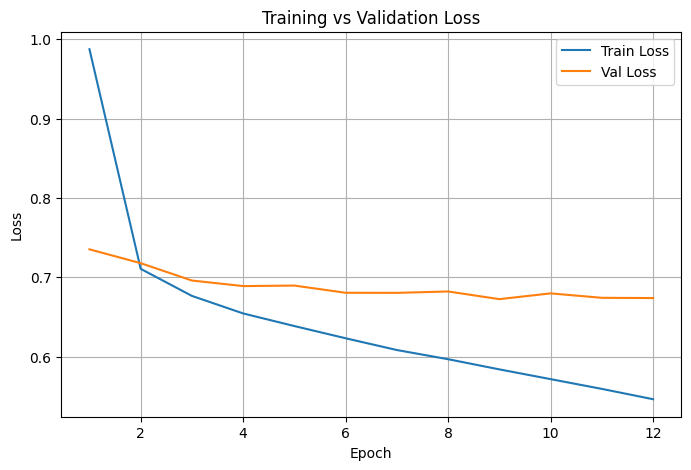

In [ ]:
# pick device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = 50
patience = 3  # stop if no improvement for n epochs
best_val_loss = float("inf")
epochs_no_improve = 0
best_model_state = None

train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    # Training
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimiser.zero_grad()
        outputs = model(batch_X.float())
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimiser.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    # Validation 
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X.float())
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}")

    # Early stopping check 
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()  # save best model
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"⏹ Early stopping at epoch {epoch+1}")
            model.load_state_dict(best_model_state)  # restore best model
            break

# Plot training & validation loss 
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_loss_history)+1), train_loss_history, label="Train Loss")
plt.plot(range(1, len(val_loss_history)+1), val_loss_history, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [26]:
with torch.no_grad():
    correct = 0
    total = 0
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.float()
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

print(f"Test Accuracy: {correct/total:.4f}")

Test Accuracy: 0.7647


In [27]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# Generate the classification report
report = classification_report(all_labels, all_preds, target_names=le.classes_)
print(report)

              precision    recall  f1-score   support

   Biography       0.68      0.65      0.66       212
    Business       0.92      0.94      0.93       254
     Cooking       0.97      0.98      0.98       289
     General       0.34      0.30      0.32       227
     History       0.73      0.69      0.71       204
    Juvenile       0.87      0.92      0.89       911
    Literary       0.54      0.44      0.48       213
     Mystery       0.59      0.56      0.58       227
    Religion       0.91      0.86      0.89       346
     Romance       0.72      0.78      0.74       330
   Thrillers       0.59      0.65      0.62       230

    accuracy                           0.76      3443
   macro avg       0.71      0.71      0.71      3443
weighted avg       0.76      0.76      0.76      3443



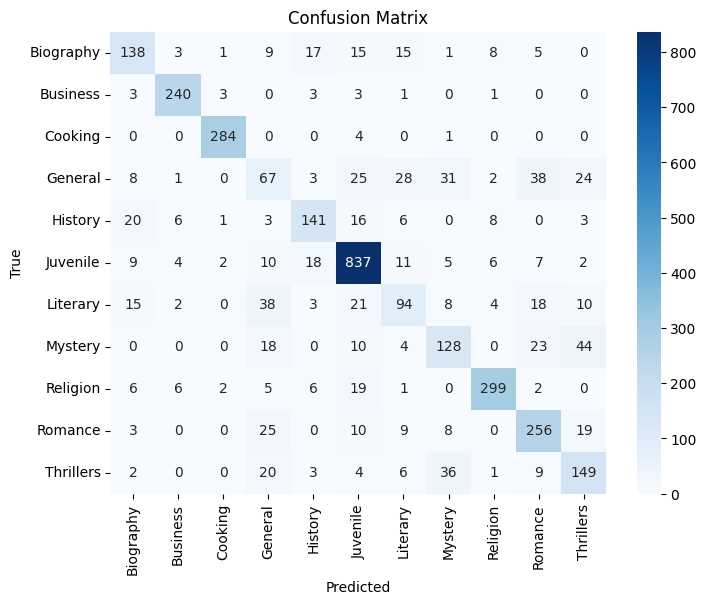

In [30]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()